In [1]:
!pip install --quiet norse
!pip install --quiet  torch

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torchvision

BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
)

In [4]:
from norse.torch import ConstantCurrentLIFEncoder

/opt/conda/lib/python3.11/site-packages/torch/utils/_cxx_pytree.py:235: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/opt/conda/lib/python3.11/site-packages/torch/utils/_cxx_pytree.py:235: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFBoxParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
2025-02-23 08:17:51.314647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740298671.335566     152 cuda_dnn.cc:8310] Unable to register cuDNN factory: Att

1


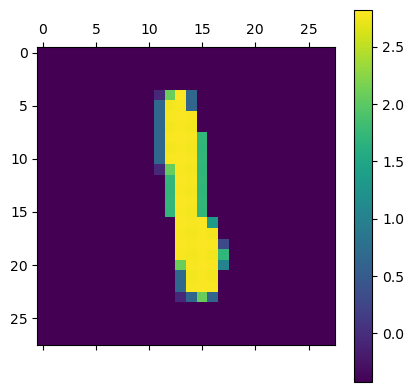

In [5]:
img, label = train_data[200]

plt.matshow(img[0])
plt.colorbar()
print(label)

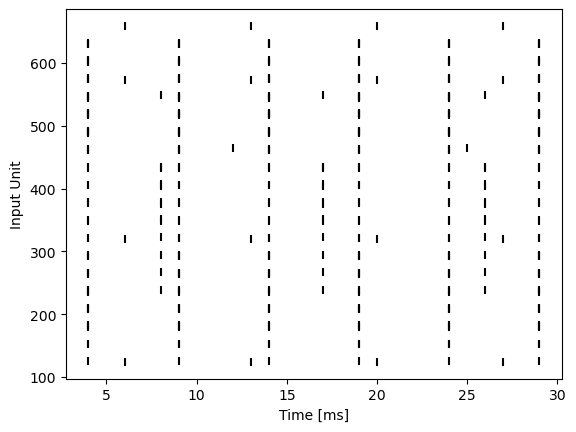

In [6]:
T = 32
example_encoder = ConstantCurrentLIFEncoder(T)

example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [7]:
from norse.torch import PoissonEncoder

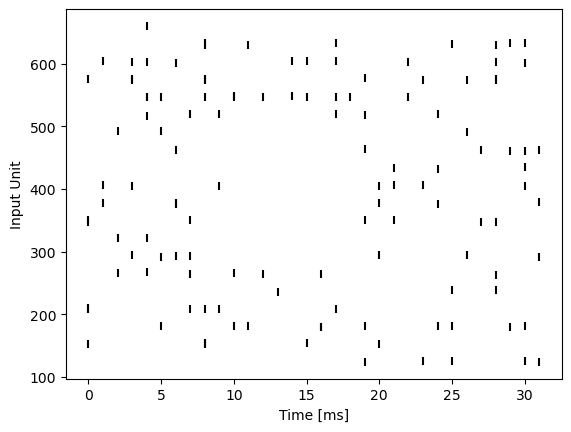

In [8]:
T = 32
example_encoder = PoissonEncoder(T, f_max=20)

example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [9]:
from norse.torch import SpikeLatencyLIFEncoder

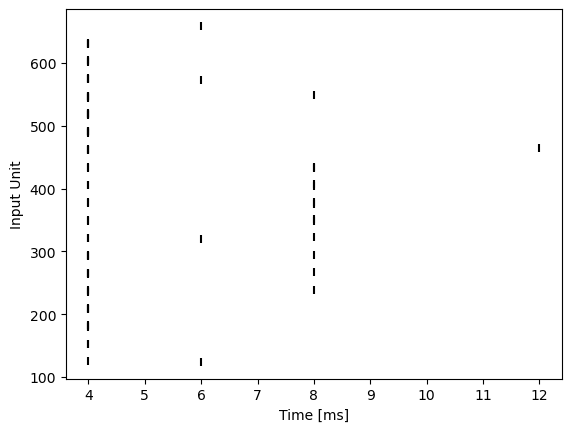

In [10]:
T = 32
example_encoder = SpikeLatencyLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [11]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self, input_features, hidden_features, output_features, record=False, dt=0.001
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

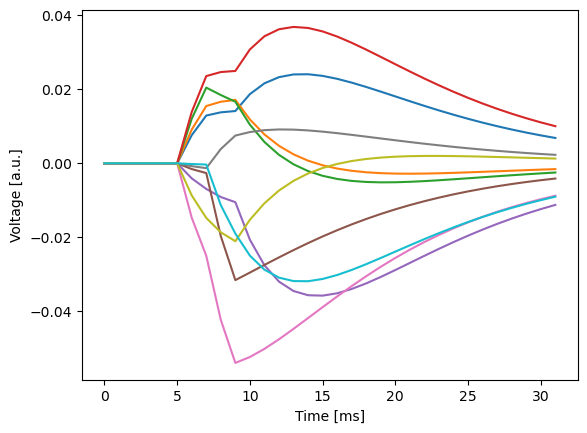

In [12]:
example_snn = SNN(28 * 28, 100, 10, record=True, dt=0.001)

example_readout_voltages = example_snn(example_input.unsqueeze(1))
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

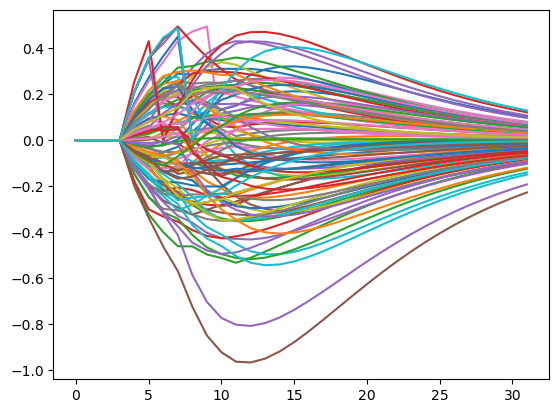

In [13]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

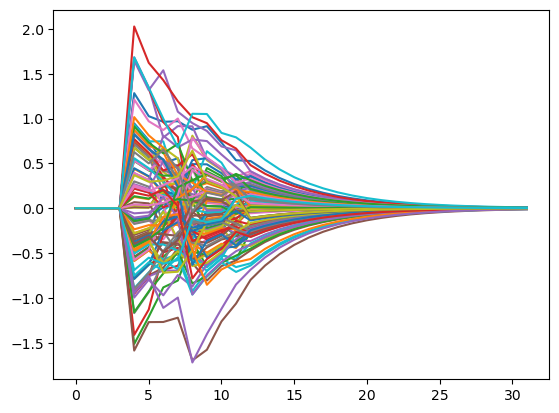

In [14]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

In [15]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [16]:
def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [17]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [18]:
# Überprüfen, ob CUDA verfügbar ist
print(torch.cuda.memory_summary())

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
import torch

print(torch.cuda.memory_summary(device=torch.device("cuda")))
torch.cuda.empty_cache()

# Hyperparameter
T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

# Modell definieren
model = Model(
    encoder=ConstantCurrentLIFEncoder(
        seq_length=T,
    ),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)
print(next(model.parameters()).device)

# Optimierer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("Modell erfolgreich initialisiert!")
print("Verwendetes Gerät:", DEVICE)


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [19]:
from torch.utils.data import random_split

# Aufteilen des Trainingsdatensatzes in Trainings- und Validierungsdatensatz
val_size = int(0.2 * len(train_data))  # 20% für Validierung
train_size = len(train_data) - val_size
train_data, val_data = random_split(train_data, [train_size, val_size])

# DataLoader für den Validierungsdatensatz
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)


In [20]:
from tqdm.notebook import tqdm, trange

EPOCHS = 60  

def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()  # Setze das Modell in den Trainingsmodus
    losses = []  # Liste für Verluste
    correct_train = 0  # Anzahl der richtigen Vorhersagen im Training
    total_train = 0  # Gesamtanzahl der Trainingsbeispiele
    
    # Schleife über den Trainingsloader
    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Setze den Gradienten des Optimierers zurück
        output = model(data)  # Modellvorhersage
        loss = torch.nn.functional.nll_loss(output, target)  # Negative log-Likelihood Loss
        loss.backward()  # Berechne Gradienten
        optimizer.step()  # Aktualisiere die Modellparameter
        losses.append(loss.item())  # Füge Verlust zur Liste hinzu
        
        # Berechne die Trainingsgenauigkeit
        pred = output.argmax(dim=1, keepdim=True)  # Bestimme die Vorhersage (Index der höchsten Log-Wahrscheinlichkeit)
        correct_train += pred.eq(target.view_as(pred)).sum().item()  # Zähle richtige Vorhersagen
        total_train += target.size(0)  # Zähle die Gesamtanzahl der Beispiele

    mean_loss = np.mean(losses)  # Berechne den Mittelwert des Verlusts über das Batch
    train_accuracy = 100.0 * correct_train / total_train  # Trainingsgenauigkeit in Prozent
    
    return losses, mean_loss, train_accuracy  # Gebe die Verluste, den Mittelwert und die Trainingsgenauigkeit zurück





In [21]:
def test(model, device, test_loader, epoch):
    model.eval()  # Setze das Modell in den Evaluationsmodus
    test_loss = 0  # Gesamtverlust
    correct = 0  # Anzahl der richtigen Vorhersagen
    
    # Deaktiviere den Gradientenberechnungsmodus
    with torch.no_grad():
        # Schleife über den Testloader
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # Modellvorhersage
            test_loss += torch.nn.functional.nll_loss(output, target, reduction="sum").item()  # Verlust addieren
            
            pred = output.argmax(dim=1, keepdim=True)  # Bestimme die Vorhersage (Index der höchsten Log-Wahrscheinlichkeit)
            correct += pred.eq(target.view_as(pred)).sum().item()  # Zähle richtige Vorhersagen
    
    test_loss /= len(test_loader.dataset)  # Durchschnittlicher Testverlust
    accuracy = 100.0 * correct / len(test_loader.dataset)  # Genauigkeit in Prozent

    return test_loss, accuracy  # Gebe Testverlust und Genauigkeit zurück


In [23]:
# Training und Testen über mehrere Epochen
train_losses = []  # Liste für durchschnittliche Trainingsverluste pro Epoche
test_losses = []   # Liste für durchschnittliche Testverluste pro Epoche
test_accuracies = []  # Liste für Testgenauigkeiten pro Epoche
train_accuracies = []  # Liste für Trainingsgenauigkeiten pro Epoche

for epoch in trange(EPOCHS, desc="Training"):
    # Training
    train_loss, mean_train_loss, train_accuracy = train(model, DEVICE, train_loader, optimizer, epoch, EPOCHS)
    train_losses.append(mean_train_loss)  # Füge den mittleren Trainingsverlust pro Epoche hinzu
    train_accuracies.append(train_accuracy)  # Füge die Trainingsgenauigkeit pro Epoche hinzu
    
    # Testen
    test_loss, test_accuracy = test(model, DEVICE, test_loader, epoch)
    test_losses.append(test_loss)  # Füge den Testverlust pro Epoche hinzu
    test_accuracies.append(test_accuracy)  # Füge die Testgenauigkeit pro Epoche hinzu
    
    # Ausgabe für jedes Epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {mean_train_loss:.4f}, "
        f"Train Accuracy: {train_accuracy:.2f}%, "
        f"Test Loss: {test_loss:.4f}, "
        f"Test Accuracy: {test_accuracy:.2f}%"
    )


Training:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 0.5342, Train Accuracy: 84.16%, Test Loss: 0.2502, Test Accuracy: 92.36%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60, Train Loss: 0.2147, Train Accuracy: 93.64%, Test Loss: 0.1800, Test Accuracy: 94.69%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60, Train Loss: 0.1601, Train Accuracy: 95.25%, Test Loss: 0.1575, Test Accuracy: 95.36%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60, Train Loss: 0.1345, Train Accuracy: 95.94%, Test Loss: 0.1440, Test Accuracy: 95.62%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60, Train Loss: 0.1173, Train Accuracy: 96.38%, Test Loss: 0.1323, Test Accuracy: 95.92%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60, Train Loss: 0.1030, Train Accuracy: 96.82%, Test Loss: 0.1319, Test Accuracy: 95.83%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60, Train Loss: 0.0871, Train Accuracy: 97.28%, Test Loss: 0.1305, Test Accuracy: 96.17%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60, Train Loss: 0.0816, Train Accuracy: 97.48%, Test Loss: 0.1197, Test Accuracy: 96.42%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60, Train Loss: 0.0697, Train Accuracy: 97.87%, Test Loss: 0.1249, Test Accuracy: 96.29%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60, Train Loss: 0.0648, Train Accuracy: 97.96%, Test Loss: 0.1245, Test Accuracy: 96.29%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60, Train Loss: 0.0577, Train Accuracy: 98.23%, Test Loss: 0.1322, Test Accuracy: 95.90%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60, Train Loss: 0.0528, Train Accuracy: 98.34%, Test Loss: 0.1211, Test Accuracy: 96.45%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60, Train Loss: 0.0499, Train Accuracy: 98.44%, Test Loss: 0.1192, Test Accuracy: 96.43%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60, Train Loss: 0.0438, Train Accuracy: 98.62%, Test Loss: 0.1157, Test Accuracy: 96.68%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60, Train Loss: 0.0426, Train Accuracy: 98.66%, Test Loss: 0.1189, Test Accuracy: 96.58%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60, Train Loss: 0.0401, Train Accuracy: 98.74%, Test Loss: 0.1232, Test Accuracy: 96.54%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60, Train Loss: 0.0385, Train Accuracy: 98.78%, Test Loss: 0.1206, Test Accuracy: 96.76%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60, Train Loss: 0.0318, Train Accuracy: 99.05%, Test Loss: 0.1366, Test Accuracy: 96.16%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60, Train Loss: 0.0322, Train Accuracy: 98.97%, Test Loss: 0.1316, Test Accuracy: 96.65%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60, Train Loss: 0.0299, Train Accuracy: 99.04%, Test Loss: 0.1216, Test Accuracy: 96.63%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60, Train Loss: 0.0242, Train Accuracy: 99.27%, Test Loss: 0.1172, Test Accuracy: 96.81%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60, Train Loss: 0.0261, Train Accuracy: 99.20%, Test Loss: 0.1297, Test Accuracy: 96.74%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60, Train Loss: 0.0275, Train Accuracy: 99.10%, Test Loss: 0.1253, Test Accuracy: 96.56%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60, Train Loss: 0.0217, Train Accuracy: 99.35%, Test Loss: 0.1253, Test Accuracy: 96.77%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60, Train Loss: 0.0231, Train Accuracy: 99.28%, Test Loss: 0.1456, Test Accuracy: 96.51%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60, Train Loss: 0.0192, Train Accuracy: 99.38%, Test Loss: 0.1361, Test Accuracy: 96.54%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60, Train Loss: 0.0172, Train Accuracy: 99.45%, Test Loss: 0.1397, Test Accuracy: 96.71%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60, Train Loss: 0.0199, Train Accuracy: 99.39%, Test Loss: 0.1345, Test Accuracy: 96.78%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60, Train Loss: 0.0197, Train Accuracy: 99.36%, Test Loss: 0.1489, Test Accuracy: 96.47%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60, Train Loss: 0.0134, Train Accuracy: 99.58%, Test Loss: 0.1532, Test Accuracy: 96.46%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60, Train Loss: 0.0187, Train Accuracy: 99.39%, Test Loss: 0.1401, Test Accuracy: 96.94%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60, Train Loss: 0.0148, Train Accuracy: 99.57%, Test Loss: 0.1397, Test Accuracy: 96.72%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60, Train Loss: 0.0181, Train Accuracy: 99.44%, Test Loss: 0.1527, Test Accuracy: 96.69%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60, Train Loss: 0.0103, Train Accuracy: 99.69%, Test Loss: 0.1492, Test Accuracy: 96.75%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60, Train Loss: 0.0141, Train Accuracy: 99.56%, Test Loss: 0.1312, Test Accuracy: 96.96%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60, Train Loss: 0.0114, Train Accuracy: 99.65%, Test Loss: 0.1516, Test Accuracy: 96.79%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60, Train Loss: 0.0159, Train Accuracy: 99.45%, Test Loss: 0.1617, Test Accuracy: 96.55%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60, Train Loss: 0.0122, Train Accuracy: 99.61%, Test Loss: 0.1531, Test Accuracy: 96.56%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60, Train Loss: 0.0148, Train Accuracy: 99.51%, Test Loss: 0.1424, Test Accuracy: 96.90%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60, Train Loss: 0.0089, Train Accuracy: 99.73%, Test Loss: 0.1615, Test Accuracy: 96.68%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60, Train Loss: 0.0103, Train Accuracy: 99.67%, Test Loss: 0.1502, Test Accuracy: 96.88%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60, Train Loss: 0.0134, Train Accuracy: 99.53%, Test Loss: 0.1519, Test Accuracy: 96.67%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60, Train Loss: 0.0080, Train Accuracy: 99.77%, Test Loss: 0.1575, Test Accuracy: 96.71%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60, Train Loss: 0.0090, Train Accuracy: 99.73%, Test Loss: 0.1747, Test Accuracy: 96.50%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60, Train Loss: 0.0085, Train Accuracy: 99.75%, Test Loss: 0.1619, Test Accuracy: 96.66%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60, Train Loss: 0.0094, Train Accuracy: 99.71%, Test Loss: 0.1657, Test Accuracy: 96.73%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60, Train Loss: 0.0145, Train Accuracy: 99.55%, Test Loss: 0.1716, Test Accuracy: 96.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60, Train Loss: 0.0144, Train Accuracy: 99.51%, Test Loss: 0.1581, Test Accuracy: 96.95%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60, Train Loss: 0.0077, Train Accuracy: 99.77%, Test Loss: 0.1774, Test Accuracy: 96.52%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60, Train Loss: 0.0048, Train Accuracy: 99.88%, Test Loss: 0.1675, Test Accuracy: 96.83%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60, Train Loss: 0.0082, Train Accuracy: 99.74%, Test Loss: 0.1658, Test Accuracy: 96.75%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60, Train Loss: 0.0104, Train Accuracy: 99.63%, Test Loss: 0.1581, Test Accuracy: 96.87%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60, Train Loss: 0.0101, Train Accuracy: 99.70%, Test Loss: 0.1536, Test Accuracy: 96.88%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60, Train Loss: 0.0080, Train Accuracy: 99.75%, Test Loss: 0.1645, Test Accuracy: 96.71%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60, Train Loss: 0.0075, Train Accuracy: 99.76%, Test Loss: 0.1611, Test Accuracy: 96.81%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60, Train Loss: 0.0067, Train Accuracy: 99.78%, Test Loss: 0.1747, Test Accuracy: 96.84%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60, Train Loss: 0.0105, Train Accuracy: 99.67%, Test Loss: 0.1737, Test Accuracy: 96.72%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60, Train Loss: 0.0092, Train Accuracy: 99.71%, Test Loss: 0.1724, Test Accuracy: 96.82%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60, Train Loss: 0.0074, Train Accuracy: 99.76%, Test Loss: 0.1756, Test Accuracy: 96.72%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60, Train Loss: 0.0066, Train Accuracy: 99.78%, Test Loss: 0.1730, Test Accuracy: 96.74%


In [24]:
# Funktion zum Normalisieren der Loss-Werte auf den Bereich [0, 1]
def normalize_loss(losses):
    max_loss = np.max(losses)
    min_loss = np.min(losses)
    return (losses - min_loss) / (max_loss - min_loss)

# Beispiel für die Normalisierung der Loss-Werte
normalized_train_losses = normalize_loss(train_losses)
normalized_test_losses = normalize_loss(test_losses)

# Normalisierung der Accuracy-Werte auf den Bereich [0, 100]
def normalize_accuracy(accuracies):
    max_accuracy = np.max(accuracies)
    min_accuracy = np.min(accuracies)
    return (accuracies - min_accuracy) * 100 / (max_accuracy - min_accuracy)

# Falls du die Accuracies normalisieren möchtest
normalized_train_accuracies = normalize_accuracy(np.array(train_accuracies))
normalized_test_accuracies = normalize_accuracy(np.array(test_accuracies))



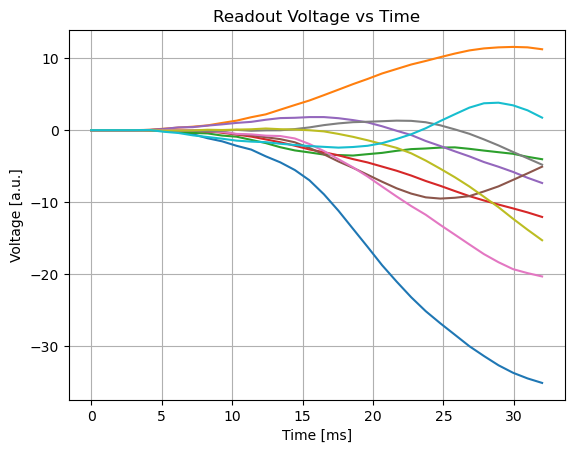

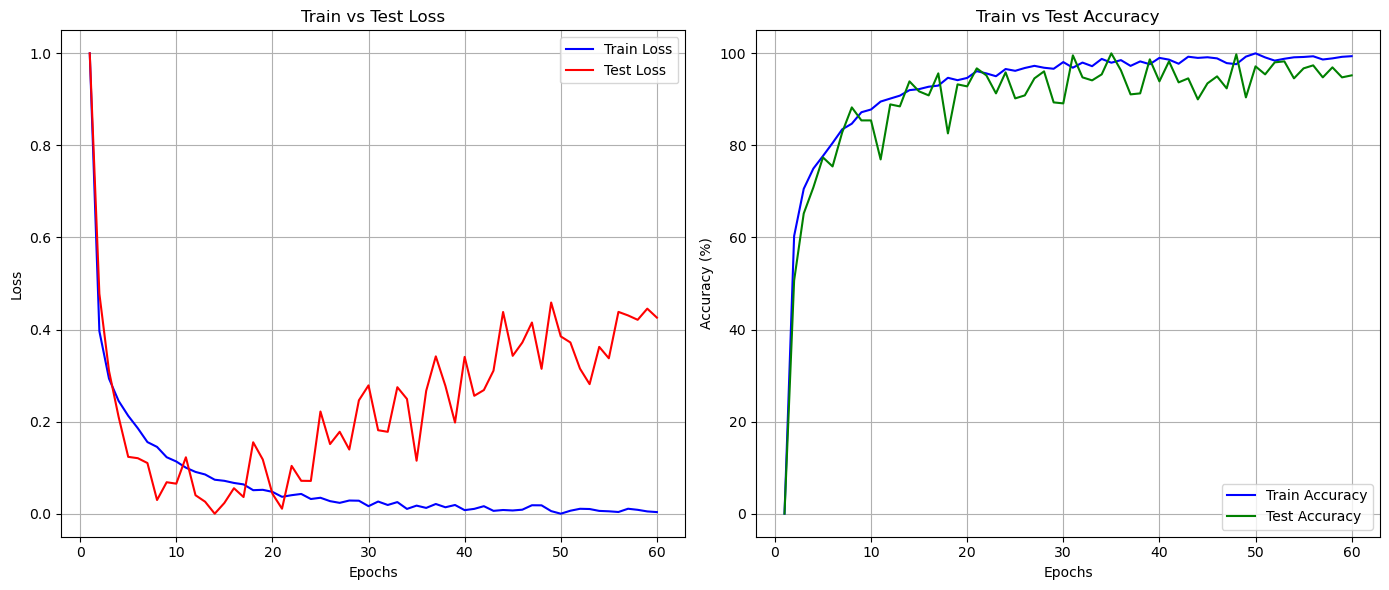

In [25]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))  # Beispiel Input
trained_readout_voltages = trained_readout_voltages.squeeze(1)  # Entfaltung der Dimensionen

# Einheitliche Zeitachse für Spannungskurven
time_steps = np.linspace(0, T, trained_readout_voltages.shape[0])

# Plot der Spannungskurve
plt.plot(time_steps, trained_readout_voltages.detach().numpy())
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.title("Readout Voltage vs Time")
plt.grid(True)
plt.show()


epochs = np.arange(1, EPOCHS + 1)

# Plotten der Verlust- und Genauigkeitsdiagramme
plt.figure(figsize=(14, 6))

# Subplot für den Verlust
plt.subplot(1, 2, 1)
plt.plot(epochs, normalized_train_losses[:EPOCHS], label="Train Loss", color="blue")
plt.plot(epochs, normalized_test_losses[:EPOCHS], label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)

# Subplot für die Genauigkeit
plt.subplot(1, 2, 2)
plt.plot(epochs, normalized_train_accuracies[:EPOCHS], label="Train Accuracy", color="blue")
plt.plot(epochs, normalized_test_accuracies[:EPOCHS], label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Modifying

In [25]:
import importlib
from norse.torch.module import encode

encode = importlib.reload(encode)

In [26]:
# from norse.torch.module import encode

T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.SpikeLatencyLIFEncoder(T),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): SpikeLatencyLIFEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [27]:
# Training und Testen über mehrere Epochen
train_losses = []  # Liste für durchschnittliche Trainingsverluste pro Epoche
test_losses = []   # Liste für durchschnittliche Testverluste pro Epoche
test_accuracies = []  # Liste für Testgenauigkeiten pro Epoche
train_accuracies = []  # Liste für Trainingsgenauigkeiten pro Epoche

for epoch in trange(EPOCHS, desc="Training"):
    # Training
    train_loss, mean_train_loss, train_accuracy = train(model, DEVICE, train_loader, optimizer, epoch, EPOCHS)
    train_losses.append(mean_train_loss)  # Füge den mittleren Trainingsverlust pro Epoche hinzu
    train_accuracies.append(train_accuracy)  # Füge die Trainingsgenauigkeit pro Epoche hinzu
    
    # Testen
    test_loss, test_accuracy = test(model, DEVICE, test_loader, epoch)
    test_losses.append(test_loss)  # Füge den Testverlust pro Epoche hinzu
    test_accuracies.append(test_accuracy)  # Füge die Testgenauigkeit pro Epoche hinzu
    
    # Ausgabe für jedes Epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {mean_train_loss:.4f}, "
        f"Train Accuracy: {train_accuracy:.2f}%, "
        f"Test Loss: {test_loss:.4f}, "
        f"Test Accuracy: {test_accuracy:.2f}%"
    )


Training:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 0.6738, Train Accuracy: 80.96%, Test Loss: 0.3068, Test Accuracy: 90.70%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60, Train Loss: 0.2941, Train Accuracy: 91.18%, Test Loss: 0.2729, Test Accuracy: 91.73%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60, Train Loss: 0.2397, Train Accuracy: 92.70%, Test Loss: 0.2261, Test Accuracy: 93.02%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60, Train Loss: 0.2113, Train Accuracy: 93.66%, Test Loss: 0.2044, Test Accuracy: 93.86%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60, Train Loss: 0.1920, Train Accuracy: 94.19%, Test Loss: 0.1812, Test Accuracy: 94.69%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60, Train Loss: 0.1710, Train Accuracy: 94.72%, Test Loss: 0.1749, Test Accuracy: 94.67%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60, Train Loss: 0.1569, Train Accuracy: 95.15%, Test Loss: 0.1707, Test Accuracy: 94.87%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60, Train Loss: 0.1456, Train Accuracy: 95.53%, Test Loss: 0.1671, Test Accuracy: 95.12%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60, Train Loss: 0.1337, Train Accuracy: 95.89%, Test Loss: 0.1725, Test Accuracy: 95.03%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60, Train Loss: 0.1313, Train Accuracy: 95.98%, Test Loss: 0.1697, Test Accuracy: 94.99%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60, Train Loss: 0.1192, Train Accuracy: 96.36%, Test Loss: 0.1546, Test Accuracy: 95.44%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60, Train Loss: 0.1138, Train Accuracy: 96.53%, Test Loss: 0.1477, Test Accuracy: 95.50%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60, Train Loss: 0.1069, Train Accuracy: 96.77%, Test Loss: 0.1539, Test Accuracy: 95.36%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60, Train Loss: 0.1034, Train Accuracy: 96.88%, Test Loss: 0.1507, Test Accuracy: 95.54%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60, Train Loss: 0.0982, Train Accuracy: 96.94%, Test Loss: 0.1467, Test Accuracy: 95.68%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60, Train Loss: 0.0931, Train Accuracy: 97.08%, Test Loss: 0.1507, Test Accuracy: 95.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60, Train Loss: 0.0938, Train Accuracy: 97.06%, Test Loss: 0.1537, Test Accuracy: 95.67%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60, Train Loss: 0.0874, Train Accuracy: 97.24%, Test Loss: 0.1413, Test Accuracy: 95.92%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60, Train Loss: 0.0819, Train Accuracy: 97.40%, Test Loss: 0.1477, Test Accuracy: 95.80%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60, Train Loss: 0.0811, Train Accuracy: 97.49%, Test Loss: 0.1347, Test Accuracy: 96.02%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60, Train Loss: 0.0753, Train Accuracy: 97.63%, Test Loss: 0.1398, Test Accuracy: 96.06%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60, Train Loss: 0.0744, Train Accuracy: 97.65%, Test Loss: 0.1404, Test Accuracy: 96.02%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60, Train Loss: 0.0694, Train Accuracy: 97.81%, Test Loss: 0.1408, Test Accuracy: 95.97%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60, Train Loss: 0.0677, Train Accuracy: 97.87%, Test Loss: 0.1345, Test Accuracy: 96.12%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60, Train Loss: 0.0642, Train Accuracy: 97.93%, Test Loss: 0.1284, Test Accuracy: 96.36%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60, Train Loss: 0.0636, Train Accuracy: 97.98%, Test Loss: 0.1373, Test Accuracy: 96.29%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60, Train Loss: 0.0592, Train Accuracy: 98.13%, Test Loss: 0.1424, Test Accuracy: 96.25%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60, Train Loss: 0.0586, Train Accuracy: 98.13%, Test Loss: 0.1428, Test Accuracy: 96.00%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60, Train Loss: 0.0552, Train Accuracy: 98.25%, Test Loss: 0.1414, Test Accuracy: 96.11%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60, Train Loss: 0.0554, Train Accuracy: 98.21%, Test Loss: 0.1345, Test Accuracy: 96.27%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60, Train Loss: 0.0507, Train Accuracy: 98.40%, Test Loss: 0.1358, Test Accuracy: 96.46%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60, Train Loss: 0.0499, Train Accuracy: 98.40%, Test Loss: 0.1480, Test Accuracy: 95.98%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60, Train Loss: 0.0516, Train Accuracy: 98.33%, Test Loss: 0.1370, Test Accuracy: 96.23%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60, Train Loss: 0.0458, Train Accuracy: 98.56%, Test Loss: 0.1344, Test Accuracy: 96.29%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60, Train Loss: 0.0443, Train Accuracy: 98.59%, Test Loss: 0.1431, Test Accuracy: 96.35%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60, Train Loss: 0.0437, Train Accuracy: 98.59%, Test Loss: 0.1373, Test Accuracy: 96.63%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60, Train Loss: 0.0422, Train Accuracy: 98.63%, Test Loss: 0.1386, Test Accuracy: 96.50%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60, Train Loss: 0.0383, Train Accuracy: 98.80%, Test Loss: 0.1479, Test Accuracy: 96.15%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60, Train Loss: 0.0390, Train Accuracy: 98.74%, Test Loss: 0.1393, Test Accuracy: 96.45%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60, Train Loss: 0.0381, Train Accuracy: 98.76%, Test Loss: 0.1496, Test Accuracy: 95.87%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60, Train Loss: 0.0380, Train Accuracy: 98.76%, Test Loss: 0.1416, Test Accuracy: 96.36%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60, Train Loss: 0.0373, Train Accuracy: 98.78%, Test Loss: 0.1447, Test Accuracy: 96.44%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60, Train Loss: 0.0319, Train Accuracy: 98.99%, Test Loss: 0.1488, Test Accuracy: 96.30%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60, Train Loss: 0.0325, Train Accuracy: 98.91%, Test Loss: 0.1376, Test Accuracy: 96.35%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60, Train Loss: 0.0314, Train Accuracy: 98.96%, Test Loss: 0.1374, Test Accuracy: 96.46%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60, Train Loss: 0.0297, Train Accuracy: 99.07%, Test Loss: 0.1403, Test Accuracy: 96.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60, Train Loss: 0.0303, Train Accuracy: 99.03%, Test Loss: 0.1503, Test Accuracy: 96.44%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60, Train Loss: 0.0308, Train Accuracy: 99.00%, Test Loss: 0.1468, Test Accuracy: 96.31%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60, Train Loss: 0.0278, Train Accuracy: 99.07%, Test Loss: 0.1436, Test Accuracy: 96.45%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60, Train Loss: 0.0260, Train Accuracy: 99.14%, Test Loss: 0.1343, Test Accuracy: 96.63%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60, Train Loss: 0.0267, Train Accuracy: 99.12%, Test Loss: 0.1511, Test Accuracy: 96.49%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60, Train Loss: 0.0232, Train Accuracy: 99.21%, Test Loss: 0.1442, Test Accuracy: 96.68%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60, Train Loss: 0.0213, Train Accuracy: 99.28%, Test Loss: 0.1480, Test Accuracy: 96.55%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60, Train Loss: 0.0261, Train Accuracy: 99.12%, Test Loss: 0.1552, Test Accuracy: 96.43%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60, Train Loss: 0.0214, Train Accuracy: 99.32%, Test Loss: 0.1580, Test Accuracy: 96.50%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60, Train Loss: 0.0217, Train Accuracy: 99.27%, Test Loss: 0.1460, Test Accuracy: 96.67%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60, Train Loss: 0.0198, Train Accuracy: 99.34%, Test Loss: 0.1510, Test Accuracy: 96.59%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60, Train Loss: 0.0197, Train Accuracy: 99.37%, Test Loss: 0.1512, Test Accuracy: 96.61%


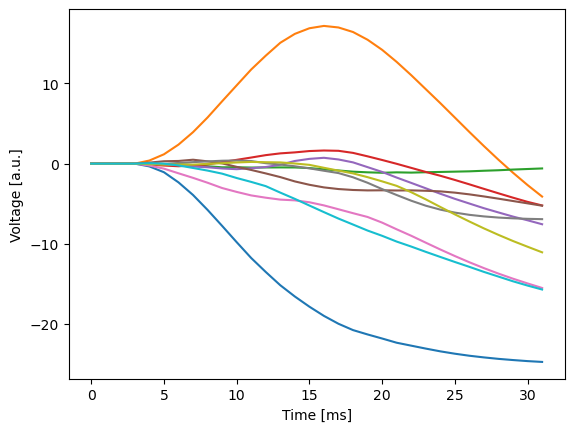

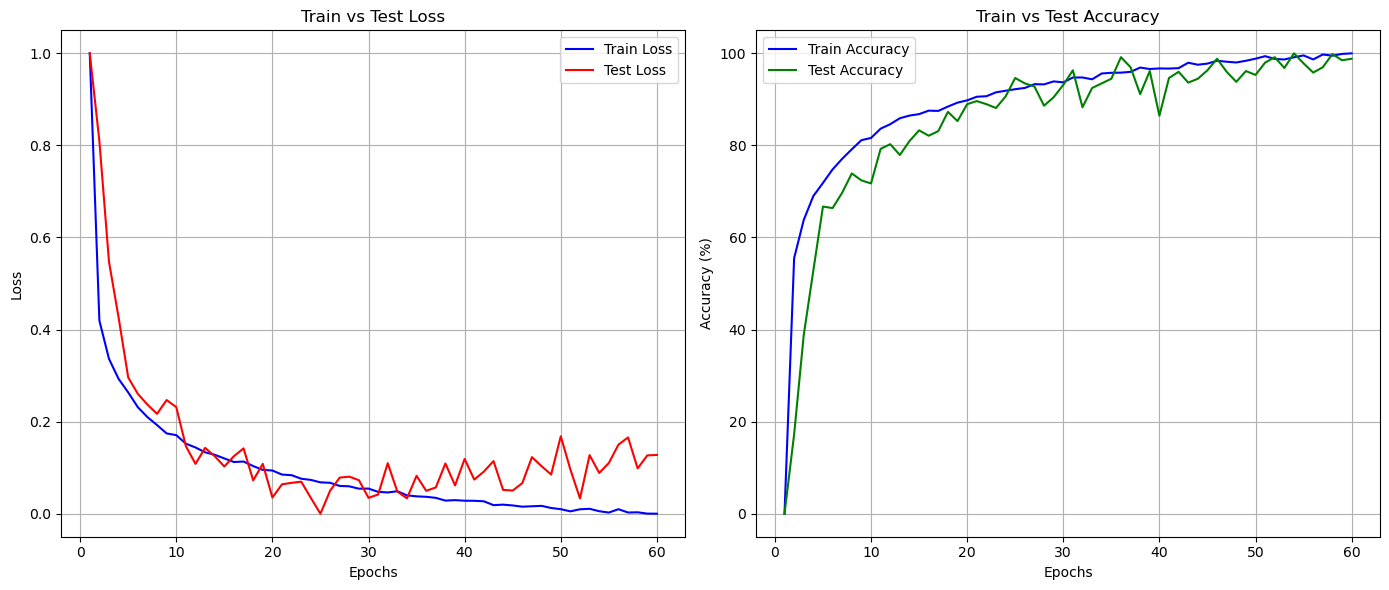

In [28]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

normalized_train_accuracies = normalize_accuracy(np.array(train_accuracies))
normalized_test_accuracies = normalize_accuracy(np.array(test_accuracies))

epochs = np.arange(1, EPOCHS + 1)

# Plotten der Verlust- und Genauigkeitsdiagramme
plt.figure(figsize=(14, 6))

# Subplot für den Verlust
plt.subplot(1, 2, 1)
plt.plot(epochs, normalized_train_losses[:EPOCHS], label="Train Loss", color="blue")
plt.plot(epochs, normalized_test_losses[:EPOCHS], label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)

# Subplot für die Genauigkeit
plt.subplot(1, 2, 2)
plt.plot(epochs, normalized_train_accuracies[:EPOCHS], label="Train Accuracy", color="blue")
plt.plot(epochs, normalized_test_accuracies[:EPOCHS], label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Poison input

In [29]:
T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.PoissonEncoder(T, f_max=20),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): PoissonEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [30]:
# Training und Testen über mehrere Epochen
train_losses = []  # Liste für durchschnittliche Trainingsverluste pro Epoche
test_losses = []   # Liste für durchschnittliche Testverluste pro Epoche
test_accuracies = []  # Liste für Testgenauigkeiten pro Epoche
train_accuracies = []  # Liste für Trainingsgenauigkeiten pro Epoche

for epoch in trange(EPOCHS, desc="Training"):
    # Training
    train_loss, mean_train_loss, train_accuracy = train(model, DEVICE, train_loader, optimizer, epoch, EPOCHS)
    train_losses.append(mean_train_loss)  # Füge den mittleren Trainingsverlust pro Epoche hinzu
    train_accuracies.append(train_accuracy)  # Füge die Trainingsgenauigkeit pro Epoche hinzu
    
    # Testen
    test_loss, test_accuracy = test(model, DEVICE, test_loader, epoch)
    test_losses.append(test_loss)  # Füge den Testverlust pro Epoche hinzu
    test_accuracies.append(test_accuracy)  # Füge die Testgenauigkeit pro Epoche hinzu
    
    # Ausgabe für jedes Epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {mean_train_loss:.2f}, "
        f"Train Accuracy: {train_accuracy:.2f}%, "
        f"Test Loss: {test_loss:.2f}, "
        f"Test Accuracy: {test_accuracy:.2f}%"
    )


Training:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 0.81, Train Accuracy: 74.22%, Test Loss: 0.49, Test Accuracy: 85.05%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60, Train Loss: 0.45, Train Accuracy: 85.99%, Test Loss: 0.40, Test Accuracy: 87.35%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60, Train Loss: 0.39, Train Accuracy: 87.89%, Test Loss: 0.36, Test Accuracy: 89.02%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60, Train Loss: 0.35, Train Accuracy: 89.05%, Test Loss: 0.34, Test Accuracy: 89.55%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60, Train Loss: 0.32, Train Accuracy: 89.97%, Test Loss: 0.31, Test Accuracy: 90.40%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60, Train Loss: 0.31, Train Accuracy: 90.23%, Test Loss: 0.30, Test Accuracy: 90.79%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60, Train Loss: 0.29, Train Accuracy: 90.83%, Test Loss: 0.29, Test Accuracy: 90.77%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60, Train Loss: 0.28, Train Accuracy: 91.10%, Test Loss: 0.26, Test Accuracy: 91.82%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60, Train Loss: 0.27, Train Accuracy: 91.54%, Test Loss: 0.25, Test Accuracy: 92.07%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60, Train Loss: 0.26, Train Accuracy: 91.70%, Test Loss: 0.27, Test Accuracy: 91.40%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60, Train Loss: 0.26, Train Accuracy: 91.86%, Test Loss: 0.25, Test Accuracy: 92.07%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60, Train Loss: 0.25, Train Accuracy: 92.28%, Test Loss: 0.24, Test Accuracy: 92.59%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60, Train Loss: 0.24, Train Accuracy: 92.31%, Test Loss: 0.23, Test Accuracy: 92.35%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60, Train Loss: 0.23, Train Accuracy: 92.72%, Test Loss: 0.24, Test Accuracy: 92.81%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60, Train Loss: 0.23, Train Accuracy: 92.73%, Test Loss: 0.23, Test Accuracy: 92.63%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60, Train Loss: 0.22, Train Accuracy: 92.99%, Test Loss: 0.22, Test Accuracy: 93.05%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60, Train Loss: 0.22, Train Accuracy: 93.30%, Test Loss: 0.23, Test Accuracy: 92.77%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60, Train Loss: 0.21, Train Accuracy: 93.34%, Test Loss: 0.22, Test Accuracy: 93.13%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60, Train Loss: 0.21, Train Accuracy: 93.60%, Test Loss: 0.21, Test Accuracy: 93.36%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60, Train Loss: 0.21, Train Accuracy: 93.62%, Test Loss: 0.24, Test Accuracy: 92.29%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60, Train Loss: 0.20, Train Accuracy: 93.55%, Test Loss: 0.20, Test Accuracy: 93.53%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60, Train Loss: 0.20, Train Accuracy: 93.80%, Test Loss: 0.20, Test Accuracy: 93.64%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60, Train Loss: 0.19, Train Accuracy: 93.89%, Test Loss: 0.20, Test Accuracy: 93.26%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60, Train Loss: 0.19, Train Accuracy: 94.00%, Test Loss: 0.21, Test Accuracy: 93.52%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60, Train Loss: 0.19, Train Accuracy: 94.16%, Test Loss: 0.20, Test Accuracy: 93.90%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60, Train Loss: 0.18, Train Accuracy: 94.17%, Test Loss: 0.20, Test Accuracy: 93.59%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60, Train Loss: 0.18, Train Accuracy: 94.33%, Test Loss: 0.19, Test Accuracy: 93.95%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60, Train Loss: 0.18, Train Accuracy: 94.46%, Test Loss: 0.19, Test Accuracy: 93.93%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60, Train Loss: 0.17, Train Accuracy: 94.54%, Test Loss: 0.19, Test Accuracy: 94.12%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60, Train Loss: 0.18, Train Accuracy: 94.37%, Test Loss: 0.19, Test Accuracy: 94.01%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60, Train Loss: 0.17, Train Accuracy: 94.49%, Test Loss: 0.19, Test Accuracy: 94.18%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60, Train Loss: 0.17, Train Accuracy: 94.63%, Test Loss: 0.19, Test Accuracy: 94.20%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60, Train Loss: 0.17, Train Accuracy: 94.70%, Test Loss: 0.20, Test Accuracy: 93.96%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60, Train Loss: 0.17, Train Accuracy: 94.68%, Test Loss: 0.17, Test Accuracy: 94.54%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60, Train Loss: 0.17, Train Accuracy: 94.55%, Test Loss: 0.18, Test Accuracy: 94.38%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60, Train Loss: 0.16, Train Accuracy: 94.80%, Test Loss: 0.18, Test Accuracy: 94.43%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60, Train Loss: 0.16, Train Accuracy: 94.87%, Test Loss: 0.18, Test Accuracy: 94.26%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60, Train Loss: 0.15, Train Accuracy: 95.07%, Test Loss: 0.17, Test Accuracy: 94.76%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60, Train Loss: 0.15, Train Accuracy: 95.06%, Test Loss: 0.18, Test Accuracy: 94.27%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60, Train Loss: 0.15, Train Accuracy: 95.20%, Test Loss: 0.18, Test Accuracy: 94.46%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60, Train Loss: 0.16, Train Accuracy: 95.05%, Test Loss: 0.16, Test Accuracy: 94.83%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60, Train Loss: 0.15, Train Accuracy: 95.09%, Test Loss: 0.16, Test Accuracy: 94.96%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60, Train Loss: 0.15, Train Accuracy: 95.20%, Test Loss: 0.16, Test Accuracy: 95.03%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60, Train Loss: 0.14, Train Accuracy: 95.40%, Test Loss: 0.17, Test Accuracy: 94.93%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60, Train Loss: 0.15, Train Accuracy: 95.23%, Test Loss: 0.16, Test Accuracy: 95.01%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60, Train Loss: 0.14, Train Accuracy: 95.37%, Test Loss: 0.16, Test Accuracy: 95.09%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60, Train Loss: 0.14, Train Accuracy: 95.46%, Test Loss: 0.17, Test Accuracy: 94.64%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60, Train Loss: 0.14, Train Accuracy: 95.52%, Test Loss: 0.15, Test Accuracy: 95.09%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60, Train Loss: 0.14, Train Accuracy: 95.39%, Test Loss: 0.15, Test Accuracy: 94.89%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60, Train Loss: 0.14, Train Accuracy: 95.50%, Test Loss: 0.15, Test Accuracy: 95.21%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60, Train Loss: 0.14, Train Accuracy: 95.66%, Test Loss: 0.16, Test Accuracy: 94.99%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60, Train Loss: 0.14, Train Accuracy: 95.60%, Test Loss: 0.17, Test Accuracy: 95.00%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60, Train Loss: 0.14, Train Accuracy: 95.67%, Test Loss: 0.14, Test Accuracy: 95.49%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60, Train Loss: 0.14, Train Accuracy: 95.59%, Test Loss: 0.16, Test Accuracy: 95.01%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60, Train Loss: 0.13, Train Accuracy: 95.82%, Test Loss: 0.16, Test Accuracy: 95.01%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60, Train Loss: 0.13, Train Accuracy: 95.89%, Test Loss: 0.16, Test Accuracy: 94.80%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60, Train Loss: 0.13, Train Accuracy: 95.87%, Test Loss: 0.16, Test Accuracy: 95.00%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60, Train Loss: 0.13, Train Accuracy: 95.94%, Test Loss: 0.15, Test Accuracy: 95.25%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60, Train Loss: 0.13, Train Accuracy: 95.87%, Test Loss: 0.14, Test Accuracy: 95.85%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60, Train Loss: 0.13, Train Accuracy: 95.91%, Test Loss: 0.16, Test Accuracy: 95.05%


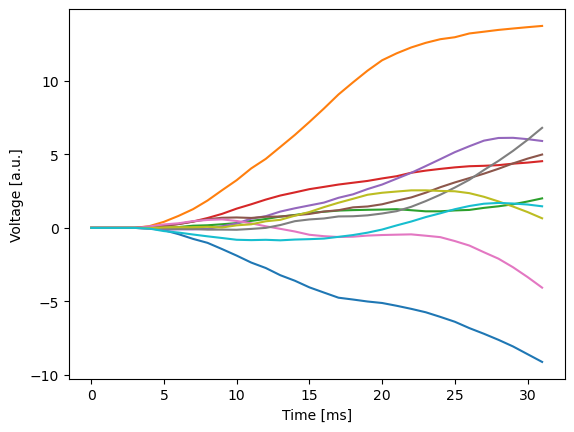

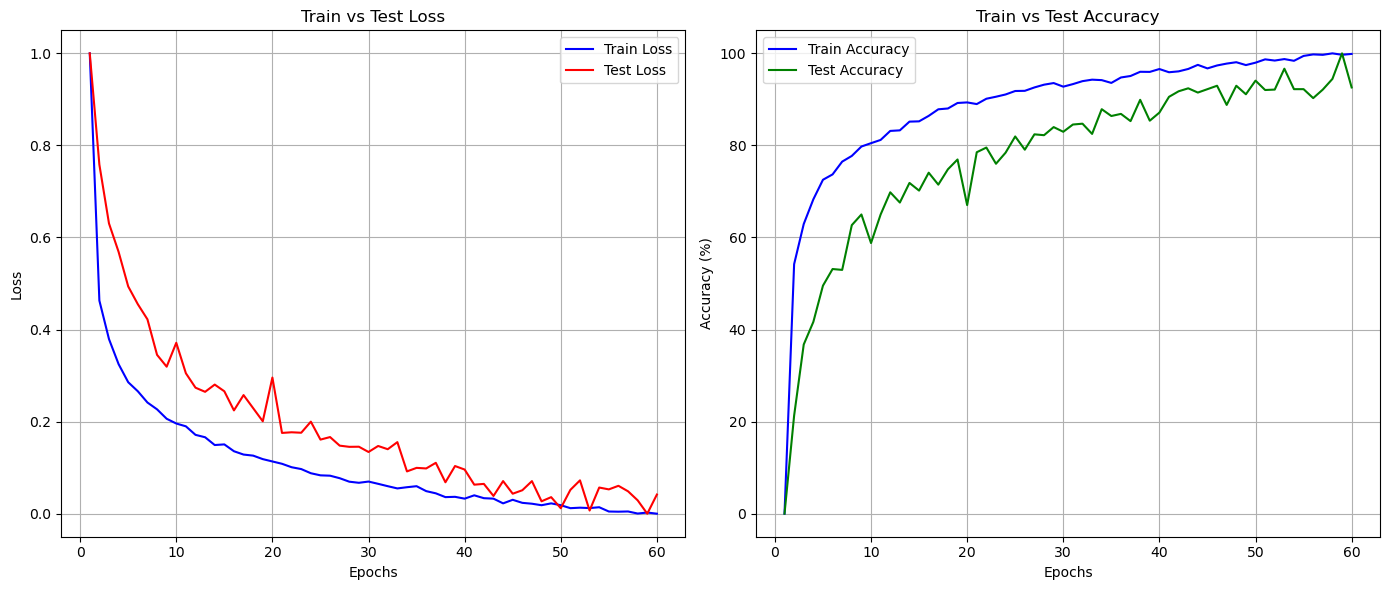

In [31]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

normalized_train_accuracies = normalize_accuracy(np.array(train_accuracies))
normalized_test_accuracies = normalize_accuracy(np.array(test_accuracies))

epochs = np.arange(1, EPOCHS + 1)

# Plotten der Verlust- und Genauigkeitsdiagramme
plt.figure(figsize=(14, 6))

# Subplot für den Verlust
plt.subplot(1, 2, 1)
plt.plot(epochs, normalized_train_losses[:EPOCHS], label="Train Loss", color="blue")
plt.plot(epochs, normalized_test_losses[:EPOCHS], label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)

# Subplot für die Genauigkeit
plt.subplot(1, 2, 2)
plt.plot(epochs, normalized_train_accuracies[:EPOCHS], label="Train Accuracy", color="blue")
plt.plot(epochs, normalized_test_accuracies[:EPOCHS], label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Convulutional SNN

In [22]:
from norse.torch.module.leaky_integrator import LILinearCell
from norse.torch.functional.lif import LIFFeedForwardState
from norse.torch.functional.leaky_integrator import LIState

from typing import NamedTuple


class ConvNet(torch.nn.Module):
    def __init__(self, num_channels=1, feature_size=28, method="super", alpha=100):
        super(ConvNet, self).__init__()

        self.features = int(((feature_size - 4) / 2 - 4) / 2)

        self.conv1 = torch.nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = torch.nn.Conv2d(20, 50, 5, 1)
        self.fc1 = torch.nn.Linear(self.features * self.features * 50, 500)
        self.lif0 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif1 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif2 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.out = LILinearCell(500, 10)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]

        # specify the initial states
        s0 = s1 = s2 = so = None

        voltages = torch.zeros(
            seq_length, batch_size, 10, device=x.device, dtype=x.dtype
        )

        for ts in range(seq_length):
            z = self.conv1(x[ts, :])
            z, s0 = self.lif0(z, s0)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = 10 * self.conv2(z)
            z, s1 = self.lif1(z, s1)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = z.view(-1, 4**2 * 50)
            z = self.fc1(z)
            z, s2 = self.lif2(z, s2)
            v, so = self.out(torch.nn.functional.relu(z), so)
            voltages[ts, :, :] = v
        return voltages

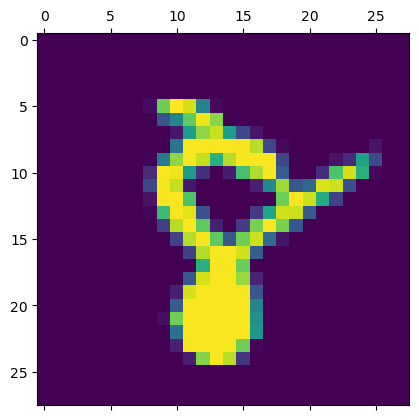

8


In [23]:
img, label = train_data[1]

plt.matshow(img[0])
plt.show()
print(label)

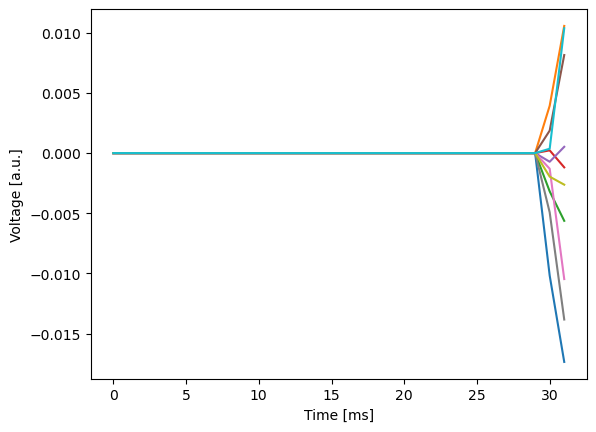

In [24]:

example_encoder = ConstantCurrentLIFEncoder(T)
example_input = example_encoder(img)
example_snn = ConvNet()
example_readout_voltages = example_snn(example_input.unsqueeze(1))


plt.plot(example_readout_voltages.squeeze(1).detach().numpy())
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

In [25]:
T = 32
LR = 0.001
EPOCHS = 60  # Increase this for improved accuracy


DEVICE = torch.device("cuda")
model = Model(
    encoder=ConstantCurrentLIFEncoder(T), snn=ConvNet(alpha=80), decoder=decode
).to(DEVICE)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)


cuda:0


In [26]:
# Training und Testen über mehrere Epochen
train_losses = []  # Liste für durchschnittliche Trainingsverluste pro Epoche
test_losses = []   # Liste für durchschnittliche Testverluste pro Epoche
test_accuracies = []  # Liste für Testgenauigkeiten pro Epoche
train_accuracies = []  # Liste für Trainingsgenauigkeiten pro Epoche

for epoch in trange(EPOCHS, desc="Training"):
    # Training
    train_loss, mean_train_loss, train_accuracy = train(model, DEVICE, train_loader, optimizer, epoch, EPOCHS)
    train_losses.append(mean_train_loss)  # Füge den mittleren Trainingsverlust pro Epoche hinzu
    train_accuracies.append(train_accuracy)  # Füge die Trainingsgenauigkeit pro Epoche hinzu
    
    # Testen
    test_loss, test_accuracy = test(model, DEVICE, test_loader, epoch)
    test_losses.append(test_loss)  # Füge den Testverlust pro Epoche hinzu
    test_accuracies.append(test_accuracy)  # Füge die Testgenauigkeit pro Epoche hinzu
    
    # Ausgabe für jedes Epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {mean_train_loss:.2f}, "
        f"Train Accuracy: {train_accuracy:.2f}%, "
        f"Test Loss: {test_loss:.2f}, "
        f"Test Accuracy: {test_accuracy:.2f}%"
    )


Training:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 0.65, Train Accuracy: 79.21%, Test Loss: 0.15, Test Accuracy: 95.54%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60, Train Loss: 0.12, Train Accuracy: 96.23%, Test Loss: 0.09, Test Accuracy: 96.96%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60, Train Loss: 0.09, Train Accuracy: 97.33%, Test Loss: 0.07, Test Accuracy: 97.53%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60, Train Loss: 0.07, Train Accuracy: 97.94%, Test Loss: 0.07, Test Accuracy: 97.74%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60, Train Loss: 0.06, Train Accuracy: 98.27%, Test Loss: 0.06, Test Accuracy: 98.12%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60, Train Loss: 0.05, Train Accuracy: 98.47%, Test Loss: 0.05, Test Accuracy: 98.36%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60, Train Loss: 0.04, Train Accuracy: 98.73%, Test Loss: 0.05, Test Accuracy: 98.42%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60, Train Loss: 0.04, Train Accuracy: 98.78%, Test Loss: 0.05, Test Accuracy: 98.43%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60, Train Loss: 0.03, Train Accuracy: 98.95%, Test Loss: 0.05, Test Accuracy: 98.50%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60, Train Loss: 0.03, Train Accuracy: 99.07%, Test Loss: 0.04, Test Accuracy: 98.53%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60, Train Loss: 0.03, Train Accuracy: 99.10%, Test Loss: 0.04, Test Accuracy: 98.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60, Train Loss: 0.02, Train Accuracy: 99.32%, Test Loss: 0.04, Test Accuracy: 98.58%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60, Train Loss: 0.02, Train Accuracy: 99.28%, Test Loss: 0.05, Test Accuracy: 98.55%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60, Train Loss: 0.02, Train Accuracy: 99.39%, Test Loss: 0.05, Test Accuracy: 98.53%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60, Train Loss: 0.02, Train Accuracy: 99.47%, Test Loss: 0.05, Test Accuracy: 98.50%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60, Train Loss: 0.02, Train Accuracy: 99.50%, Test Loss: 0.04, Test Accuracy: 98.60%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60, Train Loss: 0.01, Train Accuracy: 99.58%, Test Loss: 0.04, Test Accuracy: 98.70%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60, Train Loss: 0.01, Train Accuracy: 99.65%, Test Loss: 0.05, Test Accuracy: 98.45%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60, Train Loss: 0.01, Train Accuracy: 99.68%, Test Loss: 0.04, Test Accuracy: 98.72%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60, Train Loss: 0.01, Train Accuracy: 99.73%, Test Loss: 0.04, Test Accuracy: 98.67%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60, Train Loss: 0.01, Train Accuracy: 99.72%, Test Loss: 0.05, Test Accuracy: 98.62%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60, Train Loss: 0.01, Train Accuracy: 99.64%, Test Loss: 0.05, Test Accuracy: 98.53%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60, Train Loss: 0.01, Train Accuracy: 99.73%, Test Loss: 0.04, Test Accuracy: 98.79%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60, Train Loss: 0.01, Train Accuracy: 99.80%, Test Loss: 0.04, Test Accuracy: 98.70%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60, Train Loss: 0.01, Train Accuracy: 99.83%, Test Loss: 0.05, Test Accuracy: 98.69%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60, Train Loss: 0.01, Train Accuracy: 99.81%, Test Loss: 0.04, Test Accuracy: 98.66%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60, Train Loss: 0.01, Train Accuracy: 99.78%, Test Loss: 0.05, Test Accuracy: 98.47%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60, Train Loss: 0.01, Train Accuracy: 99.86%, Test Loss: 0.04, Test Accuracy: 98.78%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60, Train Loss: 0.00, Train Accuracy: 99.91%, Test Loss: 0.05, Test Accuracy: 98.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60, Train Loss: 0.01, Train Accuracy: 99.76%, Test Loss: 0.05, Test Accuracy: 98.66%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60, Train Loss: 0.01, Train Accuracy: 99.77%, Test Loss: 0.05, Test Accuracy: 98.56%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60, Train Loss: 0.00, Train Accuracy: 99.87%, Test Loss: 0.05, Test Accuracy: 98.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60, Train Loss: 0.00, Train Accuracy: 99.90%, Test Loss: 0.05, Test Accuracy: 98.58%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60, Train Loss: 0.00, Train Accuracy: 99.91%, Test Loss: 0.05, Test Accuracy: 98.78%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60, Train Loss: 0.00, Train Accuracy: 99.88%, Test Loss: 0.05, Test Accuracy: 98.65%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60, Train Loss: 0.00, Train Accuracy: 99.87%, Test Loss: 0.06, Test Accuracy: 98.44%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60, Train Loss: 0.01, Train Accuracy: 99.78%, Test Loss: 0.05, Test Accuracy: 98.73%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60, Train Loss: 0.00, Train Accuracy: 99.93%, Test Loss: 0.05, Test Accuracy: 98.78%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60, Train Loss: 0.00, Train Accuracy: 99.86%, Test Loss: 0.05, Test Accuracy: 98.53%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60, Train Loss: 0.00, Train Accuracy: 99.88%, Test Loss: 0.06, Test Accuracy: 98.52%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60, Train Loss: 0.00, Train Accuracy: 99.87%, Test Loss: 0.05, Test Accuracy: 98.79%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60, Train Loss: 0.00, Train Accuracy: 99.96%, Test Loss: 0.05, Test Accuracy: 98.75%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60, Train Loss: 0.00, Train Accuracy: 99.97%, Test Loss: 0.05, Test Accuracy: 98.91%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60, Train Loss: 0.00, Train Accuracy: 99.96%, Test Loss: 0.05, Test Accuracy: 98.76%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60, Train Loss: 0.00, Train Accuracy: 99.86%, Test Loss: 0.06, Test Accuracy: 98.51%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60, Train Loss: 0.01, Train Accuracy: 99.80%, Test Loss: 0.07, Test Accuracy: 98.26%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60, Train Loss: 0.00, Train Accuracy: 99.85%, Test Loss: 0.06, Test Accuracy: 98.59%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60, Train Loss: 0.00, Train Accuracy: 99.91%, Test Loss: 0.06, Test Accuracy: 98.62%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60, Train Loss: 0.00, Train Accuracy: 99.96%, Test Loss: 0.06, Test Accuracy: 98.70%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60, Train Loss: 0.00, Train Accuracy: 99.96%, Test Loss: 0.05, Test Accuracy: 98.77%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60, Train Loss: 0.00, Train Accuracy: 99.97%, Test Loss: 0.05, Test Accuracy: 98.76%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60, Train Loss: 0.00, Train Accuracy: 100.00%, Test Loss: 0.05, Test Accuracy: 98.83%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60, Train Loss: 0.00, Train Accuracy: 100.00%, Test Loss: 0.05, Test Accuracy: 98.82%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60, Train Loss: 0.00, Train Accuracy: 100.00%, Test Loss: 0.05, Test Accuracy: 98.76%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60, Train Loss: 0.00, Train Accuracy: 100.00%, Test Loss: 0.05, Test Accuracy: 98.73%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60, Train Loss: 0.00, Train Accuracy: 100.00%, Test Loss: 0.05, Test Accuracy: 98.79%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60, Train Loss: 0.00, Train Accuracy: 100.00%, Test Loss: 0.05, Test Accuracy: 98.78%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60, Train Loss: 0.00, Train Accuracy: 100.00%, Test Loss: 0.05, Test Accuracy: 98.81%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60, Train Loss: 0.00, Train Accuracy: 100.00%, Test Loss: 0.05, Test Accuracy: 98.81%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60, Train Loss: 0.00, Train Accuracy: 100.00%, Test Loss: 0.05, Test Accuracy: 98.81%


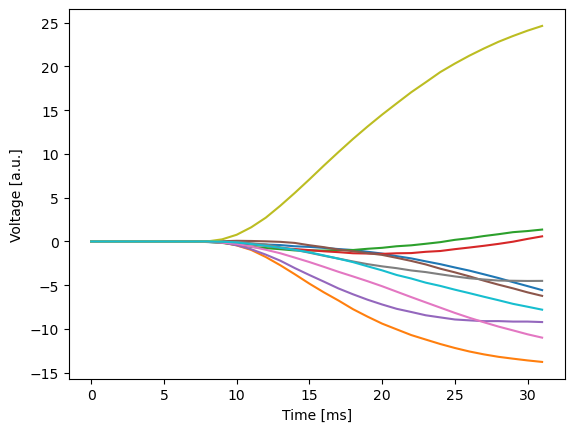

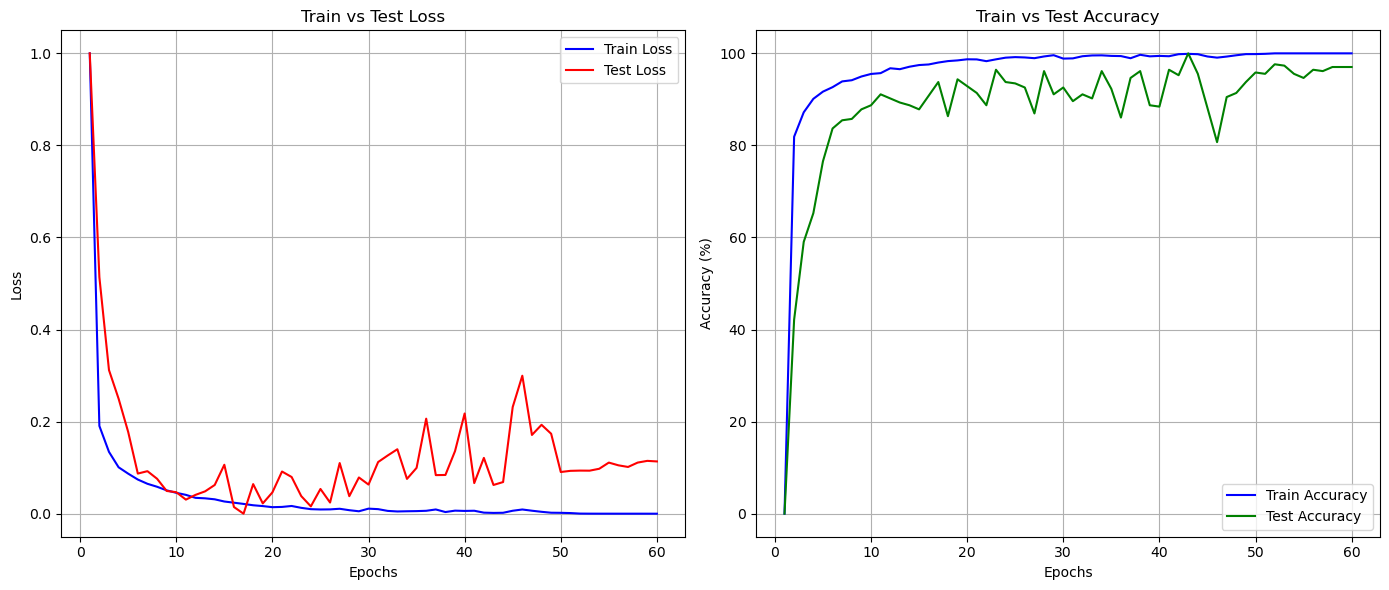

In [27]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

normalized_train_accuracies = normalize_accuracy(np.array(train_accuracies))
normalized_test_accuracies = normalize_accuracy(np.array(test_accuracies))

epochs = np.arange(1, EPOCHS + 1)

# Plotten der Verlust- und Genauigkeitsdiagramme
plt.figure(figsize=(14, 6))

# Subplot für den Verlust
plt.subplot(1, 2, 1)
plt.plot(epochs, normalized_train_losses[:EPOCHS], label="Train Loss", color="blue")
plt.plot(epochs, normalized_test_losses[:EPOCHS], label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)

# Subplot für die Genauigkeit
plt.subplot(1, 2, 2)
plt.plot(epochs, normalized_train_accuracies[:EPOCHS], label="Train Accuracy", color="blue")
plt.plot(epochs, normalized_test_accuracies[:EPOCHS], label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


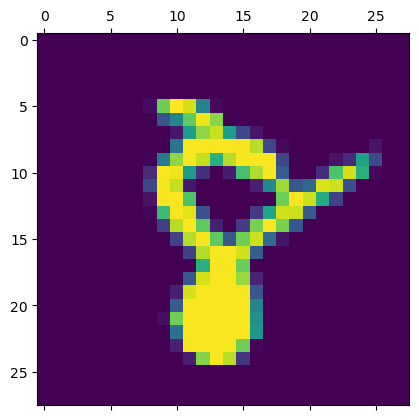

In [28]:
plt.matshow(np.squeeze(img, 0))